<a href="https://colab.research.google.com/github/victormayowa/deepFECG/blob/main/dwtdf_mem_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install -q wfdb librosa pywavelets ssqueezepy imbalanced-learn shap matplotlib opendatasets kaggle

In [3]:
import os
import math
import numpy as np
import pywt
import wfdb

from typing import List, Tuple, Optional

from scipy.signal import butter, filtfilt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import check_random_state

from imblearn.over_sampling import SMOTE

## Data Loader

In [4]:
# --- Your project paths ---
PROJECT_PATH = '/content/drive/MyDrive/MScUEL'
DATA_PATH = os.path.join(PROJECT_PATH, 'mit-bih-arrhythmia-database-1.0.0')
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'colab_outputs')
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Project path set to: {PROJECT_PATH}")
print(f"Data path set to: {DATA_PATH}")
print(f"Output path set to: {OUTPUT_PATH}")

Project path set to: /content/drive/MyDrive/MScUEL
Data path set to: /content/drive/MyDrive/MScUEL/mit-bih-arrhythmia-database-1.0.0
Output path set to: /content/drive/MyDrive/MScUEL/colab_outputs


In [5]:
AAMI_CLASSES = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,          # N
    'A': 1, 'a': 1, 'J': 1, 'S': 1,                  # S (SVEB)
    'V': 2, 'E': 2,                                  # V (VEB)
    'F': 3,                                          # F (Fusion)
    '/': 4, 'f': 4, 'Q': 4,                          # Q (Unknown / paced / artifact)
}

def get_aami_class(symbol: str):
    return AAMI_CLASSES.get(symbol)

Reading and plotting 5 random record samples:

--- Record: 112 ---
{'record_name': '112', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['54 M 903 654 x2', 'Digoxin, Pronestyl', 'There is S-T segment depression in the upper channel.'], 'sig_name': ['MLII', 'V1'], 'p_signal': array([[-0.75 , -0.62 ],
       [-0.75 , -0.62 ],
       [-0.75 , -0.62 ],
       ...,
       [-0.825, -0.59 ],
       [-0.81 , -0.58 ],
       [-1.28 ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['112.dat', '112.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [874, 900], 'checksum': [-5916, 20645], 'block_size': [0, 0]}


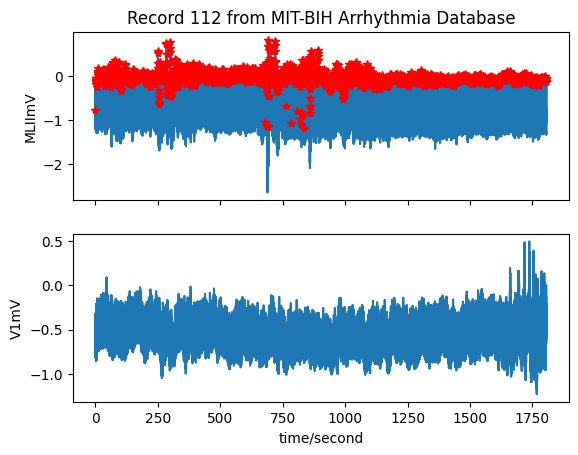


--- Record: 214 ---
{'record_name': '214', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['53 M 3189 1629 x1', 'Digoxin, Dilantin', 'The PVCs are multiform.  There are two episodes of artifactual amplitude', 'decrease and one occurrence of tape slippage.'], 'sig_name': ['MLII', 'V1'], 'p_signal': array([[-0.095,  0.025],
       [-0.095,  0.025],
       [-0.095,  0.025],
       ...,
       [-0.32 ,  0.265],
       [-0.285,  0.245],
       [ 0.   ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['214.dat', '214.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [1005, 1029], 'checksum': [-26794, -8619], 'block_size': [0, 0]}


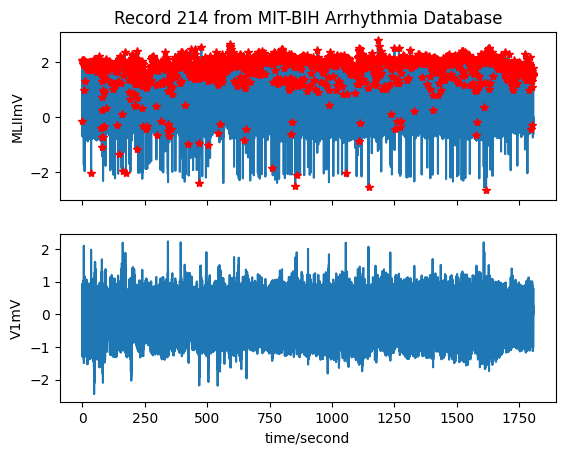


--- Record: 100 ---
{'record_name': '100', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'sig_name': ['MLII', 'V5'], 'p_signal': array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100.dat', '100.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [995, 1011], 'checksum': [-22131, 20052], 'block_size': [0, 0]}


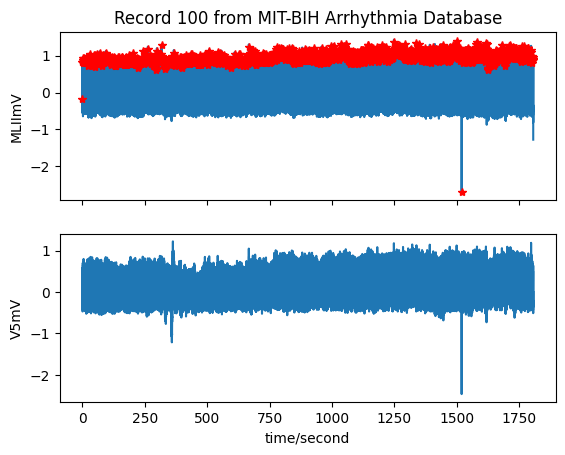


--- Record: 201 ---
{'record_name': '201', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['68 M 1960 2851 x1', 'Digoxin, Hydrochlorthiazide, Inderal, KCl', 'The PVCs are uniform and late-cycle.  Junctional escape beats occur following', 'episodes of ventricular trigeminy.'], 'sig_name': ['MLII', 'V1'], 'p_signal': array([[-0.26 , -0.21 ],
       [-0.26 , -0.21 ],
       [-0.26 , -0.21 ],
       ...,
       [-0.17 , -0.055],
       [-0.18 , -0.065],
       [ 0.   ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['201.dat', '201.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [972, 982], 'checksum': [-519, 30947], 'block_size': [0, 0]}


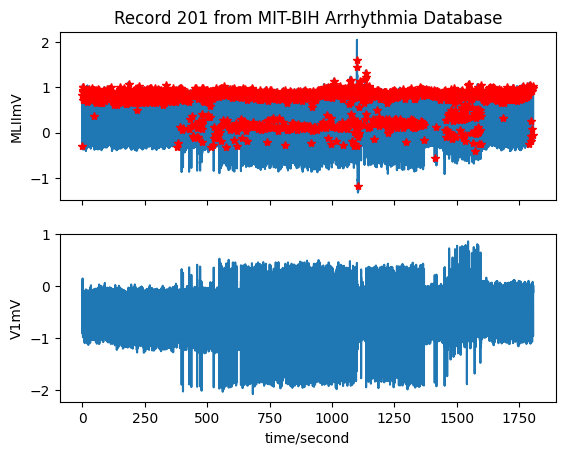


--- Record: 228 ---
{'record_name': '228', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['80 F 2775 1629 x1', 'Digoxin, Norpace', 'There is first degree AV block.  The PVCs are multiform.  There are', 'three short occurrences of tape slippage with a maximum duration of 2.2', 'seconds.'], 'sig_name': ['MLII', 'V1'], 'p_signal': array([[-0.155, -0.095],
       [-0.155, -0.095],
       [-0.155, -0.095],
       ...,
       [-0.29 , -0.11 ],
       [-0.285, -0.115],
       [ 0.   ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['228.dat', '228.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [993, 1005], 'checksum': [-22386, -28691], 'block_size': [0, 0]}


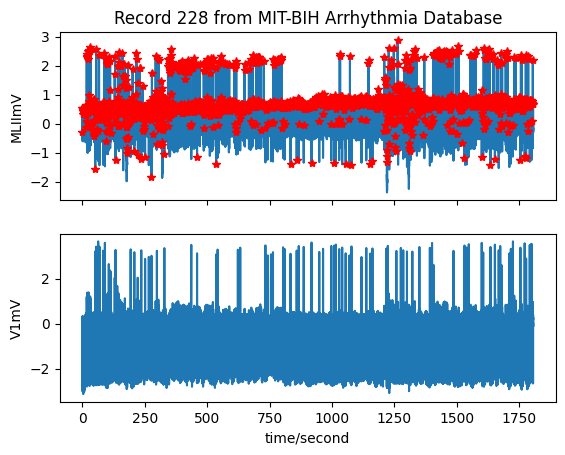

In [6]:
import wfdb
import os
import random
import matplotlib.pyplot as plt

# Get a list of all record names from the data path
record_names = sorted([f.split('.')[0] for f in os.listdir(DATA_PATH) if f.endswith('.hea')])

# Select 5 random record names
random_records = random.sample(record_names, min(5, len(record_names)))

print("Reading and plotting 5 random record samples:")

# Read and plot each selected record
for record_name in random_records:
    try:
        record_path = os.path.join(DATA_PATH, record_name)
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')

        print(f"\n--- Record: {record_name} ---")
        print(record.__dict__) # Print record details

        # Plot the record and annotations
        wfdb.plot_wfdb(record=record, annotation=annotation, title=f'Record {record_name} from MIT-BIH Arrhythmia Database', time_units='seconds')
        plt.show()

    except Exception as e:
        print(f"Could not read or plot record {record_name}: {e}")

## Signal utilities and DWT feature extraction

In [7]:
def butter_bandpass_filter(x: np.ndarray, fs: float, low=0.5, high=40.0, order=3):
    nyq = 0.5 * fs
    lowc = low / nyq
    highc = high / nyq
    b, a = butter(order, [lowc, highc], btype='band')
    return filtfilt(b, a, x, axis=0)

def zscore(x: np.ndarray, eps=1e-8):
    m = np.mean(x)
    s = np.std(x)
    return (x - m) / (s + eps)

def extract_dwt_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    # coeffs[0] = cA_level (cA4), coeffs[1:] = [cD4, cD3, ...,]
    # Reorder to get cD1..cD4, and cA4
    cA = coeffs[0]
    cDs = coeffs[1:]  # cD4, cD3, cD2, cD1
    # Reverse to [cD1, cD2, cD3, cD4]
    cDs = cDs[::-1]
    return np.hstack([*cDs, cA])


## Multi-grained scanning

In [8]:
def multi_grained_scanning(features, win_sizes):
    """
    features: 1D array of extracted features
    returns: list of 2D arrays, each being (n_windows, window_size) for each win_size
    """
    scans = []
    for w in win_sizes:
        windows = []
        for start in range(0, len(features) - w + 1):
            windows.append(features[start:start + w])
        scans.append(np.array(windows))
    return scans

def sliding_windows(x: np.ndarray, win_size: int, stride: int = 1) -> np.ndarray:
    """
    Return array of windows shape (n_windows, win_size).
    If win_size > len(x) -> returns empty array.
    """
    n = len(x)
    if win_size > n:
        return np.empty((0, win_size))
    windows = [x[i:i+win_size] for i in range(0, n - win_size + 1, stride)]
    return np.array(windows)


## Simple Cascade Forest (gcForest-like)

In [9]:
class SimpleCascadeForest:
    """
    Simplified cascade forest implementation:
      - Each layer has M forests, each forest is either RandomForest or ExtraTrees.
      - For training we grow `max_layers` layers (no early stopping implemented by default).
      - On each layer, we fit each forest on the current features and obtain class-probabilities;
        we then concatenate those prob-vectors to the features for the next layer.
      - Predict_proba returns the averaged probabilities from the last layer's forests.
    """

    def __init__(self,
                 n_forests: int = 4,    # M: total forests per layer (should be even)
                 n_trees: int = 100,    # T: trees per forest
                 max_layers: int = 3,
                 random_state: Optional[int] = None,
                 n_jobs: int = 1):
        assert n_forests % 2 == 0, "n_forests should be even (half RF, half ExtraTrees)."
        self.n_forests = n_forests
        self.n_trees = n_trees
        self.max_layers = max_layers
        self.random_state = random_state
        self.n_jobs = n_jobs

        # storage for layers: list of lists of fitted forest objects for each layer
        self.layers = []
        self.n_classes_ = None

    def _make_forest(self, kind: str):
        rs = check_random_state(self.random_state)
        seed = rs.randint(0, 2**31 - 1)
        if kind == "rf":
            return RandomForestClassifier(n_estimators=self.n_trees, n_jobs=self.n_jobs, random_state=seed)
        else:
            return ExtraTreesClassifier(n_estimators=self.n_trees, n_jobs=self.n_jobs, random_state=seed)

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        X: (n_samples, n_features)
        y: (n_samples,)
        """
        X_cur = X.copy()
        y = np.asarray(y)
        self.n_classes_ = len(np.unique(y))
        self.layers = []

        for layer_idx in range(self.max_layers):
            # create forests for this layer
            layer_forests = []
            # half RF, half ExtraTrees
            for i in range(self.n_forests // 2):
                layer_forests.append(self._make_forest("rf"))
            for i in range(self.n_forests // 2):
                layer_forests.append(self._make_forest("et"))

            # fit each forest and collect class-probabilities
            probs_list = []
            for f in layer_forests:
                f.fit(X_cur, y)
                probs = f.predict_proba(X_cur)  # (n_samples, n_classes)
                probs_list.append(probs)

            # concatenate probabilities from all forests horizontally
            probs_concat = np.hstack(probs_list)  # (n_samples, n_forests * n_classes)

            # update X_cur by concatenating original features with probs (as in gcForest)
            X_cur = np.hstack([X_cur, probs_concat])

            # store fitted forests for this layer
            self.layers.append(layer_forests)

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        For each layer, compute probability outputs and augment features sequentially.
        Final returned prob is the average of the last layer's forests probability outputs.
        """
        X_cur = X.copy()
        last_layer_probs = None

        for layer_forests in self.layers:
            probs_list = []
            for f in layer_forests:
                probs = f.predict_proba(X_cur)
                probs_list.append(probs)
            probs_concat = np.hstack(probs_list)
            # avg of forests in this layer
            # each probs_list element shape: (n_samples, n_classes)
            avg_probs = sum(probs_list) / len(probs_list)
            last_layer_probs = avg_probs  # save last layer average
            # augment feature set for next layer
            X_cur = np.hstack([X_cur, probs_concat])

        return last_layer_probs  # (n_samples, n_classes)

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)



## DWT-driven gcForest

In [10]:
class DWT_gcForest_Pipeline:
    def __init__(self,
                 wavelet: str = "db4",
                 dwt_level: int = 4,
                 win_sizes: List[int] = [32, 64, 128],
                 stride: int = 1,
                 cascade_kwargs: dict = None):
        self.wavelet = wavelet
        self.dwt_level = dwt_level
        self.win_sizes = win_sizes
        self.stride = stride
        self.cascade_kwargs = cascade_kwargs or {"n_forests": 4, "n_trees": 100, "max_layers": 2, "random_state": 42}
        self.cascades = [SimpleCascadeForest(**self.cascade_kwargs) for _ in self.win_sizes]
        self.n_classes_ = None

    # --- training from RAW signals (computes DWT internally) ---
    def _prepare_scans_labels_from_signals(self, signals: np.ndarray, labels: np.ndarray):
        scans = []
        for w in self.win_sizes:
            X_list, y_list = [], []
            for sig, lbl in zip(signals, labels):
                feats = extract_dwt_features(sig, wavelet=self.wavelet, level=self.dwt_level)
                windows = sliding_windows(feats, win_size=w, stride=self.stride)
                if windows.size == 0:
                    continue
                X_list.append(windows)
                y_list.append(np.full(windows.shape[0], lbl, dtype=labels.dtype))
            X_scan = np.vstack(X_list) if X_list else np.empty((0, w))
            y_scan = np.concatenate(y_list) if y_list else np.empty((0,), dtype=labels.dtype)
            scans.append((X_scan, y_scan))
        return scans

    # --- training from PRECOMPUTED DWT features (for SMOTE) ---
    def _prepare_scans_labels_from_features(self, feats: np.ndarray, labels: np.ndarray):
        scans = []
        for w in self.win_sizes:
            X_list, y_list = [], []
            for fvec, lbl in zip(feats, labels):
                windows = sliding_windows(fvec, win_size=w, stride=self.stride)
                if windows.size == 0:
                    continue
                X_list.append(windows)
                y_list.append(np.full(windows.shape[0], lbl, dtype=labels.dtype))
            X_scan = np.vstack(X_list) if X_list else np.empty((0, w))
            y_scan = np.concatenate(y_list) if y_list else np.empty((0,), dtype=labels.dtype)
            scans.append((X_scan, y_scan))
        return scans

    def fit_from_features(self, X_feats: np.ndarray, y: np.ndarray):
        """Use when you've applied SMOTE on DWT features."""
        self.n_classes_ = len(np.unique(y))
        scans = self._prepare_scans_labels_from_features(X_feats, y)
        for (X_scan, y_scan), cascade in zip(scans, self.cascades):
            if X_scan.shape[0] == 0:
                raise ValueError("No windows produced; adjust win_sizes/stride.")
            cascade.fit(X_scan, y_scan)
        return self

    def fit(self, signals: np.ndarray, labels: np.ndarray):
        """Compute DWT internally and fit (no SMOTE)."""
        self.n_classes_ = len(np.unique(labels))
        scans = self._prepare_scans_labels_from_signals(signals, labels)
        for (X_scan, y_scan), cascade in zip(scans, self.cascades):
            if X_scan.shape[0] == 0:
                raise ValueError("No windows produced; adjust win_sizes/stride.")
            cascade.fit(X_scan, y_scan)
        return self

    def predict_from_features(self, X_feats: np.ndarray) -> np.ndarray:
        preds = []
        for fvec in X_feats:
            agg = None
            for w, cascade in zip(self.win_sizes, self.cascades):
                windows = sliding_windows(fvec, win_size=w, stride=self.stride)
                if windows.shape[0] == 0:
                    continue
                proba = cascade.predict_proba(windows)   # (n_windows, n_classes)
                summed = proba.sum(axis=0)
                agg = summed if agg is None else agg + summed
            preds.append(int(np.argmax(agg)) if agg is not None else 0)
        return np.array(preds)


## Evaluation helper

In [11]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "recall":    recall_score(y_true, y_pred, average="macro", zero_division=0),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "f1":        f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

## Data loading & preprocessing

In [12]:
def choose_channel_index(record) -> int:
    """Prefer MLII if available, else channel 0."""
    names = [s.upper() for s in record.sig_name]
    if "MLII" in names:
        return names.index("MLII")
    return 0

def preprocess_data(data_path: str,
                    window_size: int = 360,
                    max_records: Optional[int] = None,
                    low_hz: float = 0.5,
                    high_hz: float = 40.0) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Extracts beat-centered segments of length `window_size` (samples),
    band-pass filters, z-scores, and maps to AAMI classes.
    Returns: (signals, labels, fs)
    """
    print("Starting data preprocessing...")
    hea_files = sorted([f for f in os.listdir(data_path) if f.endswith('.hea')])
    if max_records is not None:
        hea_files = hea_files[:max_records]

    all_segments, all_labels = [], []
    fs_global = None

    for i, hea in enumerate(hea_files, 1):
        rec = os.path.splitext(hea)[0]
        rec_path = os.path.join(data_path, rec)

        try:
            record = wfdb.rdrecord(rec_path)
            ann = wfdb.rdann(rec_path, 'atr')
        except Exception as e:
            print(f"Skipping {rec}: {e}")
            continue

        fs = float(record.fs)
        if fs_global is None:
            fs_global = fs
        elif abs(fs - fs_global) > 1e-6:
            print(f"Warning: sampling rate changed in {rec} ({fs} vs {fs_global}).")

        ch_idx = choose_channel_index(record)
        sig = record.p_signal[:, ch_idx].astype(float)

        # filter entire signal (optional but recommended)
        try:
            sig_f = butter_bandpass_filter(sig, fs=fs, low=low_hz, high=high_hz, order=3)
        except Exception:
            sig_f = sig  # fallback if filter fails

        half = window_size // 2
        N = len(sig_f)

        for samp, sym in zip(ann.sample, ann.symbol):
            cls = get_aami_class(sym)
            if cls is None:
                continue
            start = int(samp) - half
            end = start + window_size
            if start < 0 or end > N:
                continue
            seg = sig_f[start:end]
            seg = zscore(seg)
            all_segments.append(seg)
            all_labels.append(cls)

        if i % 10 == 0 or i == len(hea_files):
            print(f"Processed {i}/{len(hea_files)} records... total beats: {len(all_segments)}")

    signals = np.array(all_segments, dtype=np.float32)
    labels = np.array(all_labels, dtype=np.int64)
    print(f"Done. Segments: {signals.shape}, Class counts: {np.bincount(labels)}")
    return signals, labels, (fs_global if fs_global is not None else 360.0)

## MAIN: run experiment

In [ ]:
# 1) Load & preprocess all records
signals, labels, fs = preprocess_data(
    DATA_PATH,
    window_size=360,        # ~1s at 360 Hz
    max_records=None,       # set an int (e.g., 10) to debug faster
    low_hz=0.5,
    high_hz=40.0
)

# 2) Train/test split (stratified)
X_train_sig, X_test_sig, y_train, y_test = train_test_split(
    signals, labels, test_size=0.2, random_state=42, stratify=labels
)

# 3) Compute DWT features per-beat
X_train_feats = np.stack([extract_dwt_features(x, wavelet='db4', level=4) for x in X_train_sig])
X_test_feats  = np.stack([extract_dwt_features(x, wavelet='db4', level=4) for x in X_test_sig])

# 4) SMOTE on training features ONLY
print("Applying SMOTE on training DWT features...")
sm = SMOTE(random_state=42) # Removed n_jobs=-1
X_train_sm, y_train_sm = sm.fit_resample(X_train_feats, y_train)
print("After SMOTE class counts:", np.bincount(y_train_sm))

# 5) Train DWT->Scanning->Cascade on oversampled FEATURES
pipeline = DWT_gcForest_Pipeline(
    wavelet="db4",
    dwt_level=4,
    win_sizes=[32, 64, 128],         # multi-grained scanning window sizes
    stride=1,
    cascade_kwargs={"n_forests": 4, "n_trees": 100, "max_layers": 2, "random_state": 42, "n_jobs": 2}
)

print("Fitting cascade forest (from DWT features, post-SMOTE)...")
pipeline.fit_from_features(X_train_sm, y_train_sm)

# 6) Predict on TEST DWT features
print("Predicting...")
y_pred = pipeline.predict_from_features(X_test_feats)

# 7) Evaluate
scores = evaluate(y_test, y_pred)
print("\n=== Test Performance (AAMI 5-class) ===")
print(f"Accuracy : {scores['accuracy']*100:.2f}%")
print(f"Recall   : {scores['recall']*100:.2f}%")
print(f"Precision: {scores['precision']*100:.2f}%")
print(f"F1-score : {scores['f1']*100:.2f}%")

Starting data preprocessing...
Processed 10/48 records... total beats: 21657
Processed 20/48 records... total beats: 42011
Processed 30/48 records... total beats: 64763
Processed 40/48 records... total beats: 90867
Processed 48/48 records... total beats: 109438
Done. Segments: (109438, 360), Class counts: [90582  2781  7235   802  8038]
Applying SMOTE on training DWT features...
After SMOTE class counts: [72465 72465 72465 72465 72465]
Fitting cascade forest (from DWT features, post-SMOTE)...


# DF_standalone

In [ ]:
# # This notebook contains core Deep Forest functionality extracted for standalone use.
# # It aims to provide a functional version without requiring full package installation,
# # especially bypassing Cython compilation issues.

# import numpy as np
# from datetime import datetime
# from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
# from sklearn.utils import check_random_state, check_array
# from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
# from sklearn.tree import DecisionTreeRegressor as SklearnDecisionTreeRegressor
# from sklearn.ensemble import BaggingClassifier, BaggingRegressor
# from sklearn.preprocessing import LabelEncoder
# import joblib
# import copy

# # --- deepforest/_utils.py content ---

# # Original: from . import _cutils as _LIB
# # Removed Cython dependency. This function will now be a pure Python placeholder.
# def merge_proba(probas, n_outputs):
#     """
#     Merge an array that stores multiple class distributions from all estimators
#     in a cascade layer into a final class distribution.

#     NOTE: This is a simplified pure Python implementation as the original relies on Cython.
#     It might not be as performant as the original Cython version.
#     """
#     n_samples, n_features = probas.shape

#     if n_features % n_outputs != 0:
#         msg = "The dimension of probas = {} does not match n_outputs = {}."
#         raise RuntimeError(msg.format(n_features, n_outputs))

#     # Original: _LIB._c_merge_proba(probas, n_outputs, proba)
#     # Simplified pure Python equivalent:
#     # This assumes a simple averaging or summation. The exact logic of _c_merge_proba
#     # would need to be replicated if more complex.
#     proba = np.zeros((n_samples, n_outputs), dtype=probas.dtype)
#     start_idx = 0
#     while start_idx < n_features:
#         proba += probas[:, start_idx : start_idx + n_outputs]
#         start_idx += n_outputs

#     # Assuming it was an average, as per the original _c_merge_proba usage in _forest.py
#     # where it was divided by 'count'
#     num_estimators_per_output = n_features // n_outputs
#     if num_estimators_per_output > 0:
#         proba /= num_estimators_per_output

#     return proba

# def init_array(X, n_aug_features):
#     """
#     Initialize a array that stores the intermediate data used for training
#     or evaluating the model.
#     """
#     if X.dtype != np.uint8:
#         msg = "The input `X` when creating the array should be binned."
#         raise ValueError(msg)

#     # Create the global array that stores both X and X_aug
#     n_samples, n_features = X.shape
#     n_dims = n_features + n_aug_features
#     X_middle = np.zeros((n_samples, n_dims), dtype=np.uint8)
#     X_middle[:, :n_features] = X

#     return X_middle

# def merge_array(X_middle, X_aug, n_features):
#     """
#     Update the array created by `init_array`  with additional checks on the
#     layout.
#     """

#     if X_aug.dtype != np.uint8:
#         msg = "The input `X_aug` when merging the array should be binned."
#         raise ValueError(msg)

#     assert X_middle.shape[0] == X_aug.shape[0]  # check n_samples
#     assert X_middle.shape[1] == n_features + X_aug.shape[1]  # check n_features
#     X_middle[:, n_features:] = X_aug

#     return X_middle

# def ctime():
#     """A formatter on current time used for printing running status."""
#     ctime = "[" + datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] + "]"
#     return ctime

# # --- deepforest/_binner.py content ---

# X_DTYPE = np.float64
# X_BINNED_DTYPE = np.uint8
# ALMOST_INF = 1e300

# def _map_num_col_to_bins(data, binning_thresholds, missing_values_bin_idx):
#     """Binary search to find the bin index for each value in the data."""
#     binned = np.zeros_like(data, dtype=X_BINNED_DTYPE)
#     for i in range(data.shape[0]):
#         if np.isnan(data[i]):
#             binned[i] = missing_values_bin_idx
#         else:
#             # for known values, use binary search
#             left, right = 0, len(binning_thresholds)
#             while left < right:
#                 middle = (right + left - 1) // 2
#                 if data[i] <= binning_thresholds[middle]:
#                     right = middle
#                 else:
#                     left = middle + 1
#             binned[i] = left
#     return binned

# def _map_to_bins(X, binning_thresholds, missing_values_bin_idx, binned):
#     """Bin numerical values to discrete integer-coded levels."""
#     n_features = X.shape[1]
#     for feature_idx in range(n_features):
#         binned[:, feature_idx] = _map_num_col_to_bins(
#             X[:, feature_idx],
#             binning_thresholds[feature_idx],
#             missing_values_bin_idx
#         )

# class Binner(BaseEstimator, TransformerMixin):
#     def __init__(self, n_bins=256, random_state=None):
#         self.n_bins = n_bins
#         self.random_state = random_state
#         self.binning_thresholds_ = None
#         self.missing_values_bin_idx_ = None

#     def fit(self, X, y=None):
#         X = check_array(X, dtype=X_DTYPE, accept_sparse=False)
#         n_samples, n_features = X.shape
#         rng = check_random_state(self.random_state)

#         self.binning_thresholds_ = []
#         self.missing_values_bin_idx_ = self.n_bins - 1 # Last bin for missing values

#         for feature_idx in range(n_features):
#             col_data = X[:, feature_idx]
#             finite_data = col_data[~np.isnan(col_data)]
#             if len(finite_data) == 0:
#                 self.binning_thresholds_.append(np.array([]))
#                 continue

#             # Use percentiles to find bin thresholds
#             quantiles = np.linspace(0, 100, self.n_bins - 1) # n_bins - 1 thresholds
#             thresholds = np.percentile(finite_data, quantiles)
#             self.binning_thresholds_.append(np.unique(thresholds)) # Ensure unique thresholds
#         return self

#     def transform(self, X):
#         X = check_array(X, dtype=X_DTYPE, accept_sparse=False)
#         n_samples, n_features = X.shape
#         binned = np.zeros_like(X, dtype=X_BINNED_DTYPE)
#         _map_to_bins(X, self.binning_thresholds_, self.missing_values_bin_idx_, binned)
#         return binned

#     def fit_transform(self, X, y=None):
#         return self.fit(X, y).transform(X)

# # --- deepforest/_estimator.py content ---

# class BaseEstimatorWrapper(BaseEstimator):
#     def __init__(self, estimator=None):
#         self.estimator = estimator

#     def fit(self, X, y, sample_weight=None):
#         if sample_weight is not None:
#             self.estimator.fit(X, y, sample_weight=sample_weight)
#         else:
#             self.estimator.fit(X, y)
#         return self

#     def predict(self, X):
#         return self.estimator.predict(X)

#     def predict_proba(self, X):
#         if hasattr(self.estimator, "predict_proba"):
#             return self.estimator.predict_proba(X)
#         raise AttributeError("Estimator does not have predict_proba method.")

#     def get_params(self, deep=True):
#         return self.estimator.get_params(deep=deep)

#     def set_params(self, **params):
#         self.estimator.set_params(**params)
#         return self

# class ClassifierEstimator(BaseEstimatorWrapper, ClassifierMixin):
#     pass

# class RegressorEstimator(BaseEstimatorWrapper, RegressorMixin):
#     pass

# # --- deepforest/_io.py content ---

# def save_model(model, filepath):
#     """Save a DeepForest model to a file.

#     Parameters
#     ----------
#     model : object
#         The DeepForest model to save.
#     filepath : str
#         The path to the file where the model will be saved.
#     """
#     joblib.dump(model, filepath)

# def load_model(filepath):
#     """Load a DeepForest model from a file.

#     Parameters
#     ----------
#     filepath : str
#         The path to the file from which the model will be loaded.

#     Returns
#     -------
#     object
#         The loaded DeepForest model.
#     """
#     return joblib.load(filepath)

# # --- Pure Python equivalent of deepforest/_forest.pyx content ---
# # This section replaces the Cython implementation of ForestClassifier and ForestRegressor.
# # It uses sklearn.tree.DecisionTreeClassifier and DecisionTreeRegressor internally,
# # wrapped by BaggingClassifier/Regressor to mimic ensemble behavior.

# class ForestClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1,
#                  max_features=1.0, random_state=None, n_jobs=None):
#         self.n_estimators = n_estimators
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.forest = None

#     def fit(self, X, y, sample_weight=None):
#         base_estimator = SklearnDecisionTreeClassifier(
#             max_depth=self.max_depth,
#             min_samples_leaf=self.min_samples_leaf,
#             random_state=self.random_state
#         )
#         self.forest = BaggingClassifier(
#             estimator=base_estimator,
#             n_estimators=self.n_estimators,
#             max_features=self.max_features,
#             random_state=self.random_state,
#             n_jobs=self.n_jobs
#         )
#         self.forest.fit(X, y, sample_weight=sample_weight)
#         return self

#     def predict(self, X):
#         return self.forest.predict(X)

#     def predict_proba(self, X):
#         return self.forest.predict_proba(X)

#     def get_params(self, deep=True):
#         return {
#             'n_estimators': self.n_estimators,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs
#         }

#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

# class ForestRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1,
#                  max_features=1.0, random_state=None, n_jobs=None):
#         self.n_estimators = n_estimators
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.forest = None

#     def fit(self, X, y, sample_weight=None):
#         base_estimator = SklearnDecisionTreeRegressor(
#             max_depth=self.max_depth,
#             min_samples_leaf=self.min_samples_leaf,
#             random_state=self.random_state
#         )
#         self.forest = BaggingRegressor(
#             estimator=base_estimator,
#             n_estimators=self.n_estimators,
#             max_features=self.max_features,
#             random_state=self.random_state,
#             n_jobs=self.n_jobs
#         )
#         self.forest.fit(X, y, sample_weight=sample_weight)
#         return self

#     def predict(self, X):
#         return self.forest.predict(X)

#     def get_params(self, deep=True):
#         return {
#             'n_estimators': self.n_estimators,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs
#         }

#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

# # --- deepforest/_layer.py content ---

# class CascadeLayer(BaseEstimator, ClassifierMixin, RegressorMixin):
#     def __init__(self, n_estimators=2, estimator_type="classifier",
#                  n_trees=100, max_depth=None, min_samples_leaf=1,
#                  max_features=1.0, random_state=None, n_jobs=None):
#         self.n_estimators = n_estimators
#         self.estimator_type = estimator_type
#         self.n_trees = n_trees
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.estimators_ = []
#         self.binner_ = None

#     def _make_estimator(self):
#         if self.estimator_type == "classifier":
#             return ForestClassifier(
#                 n_estimators=self.n_trees,
#                 max_depth=self.max_depth,
#                 min_samples_leaf=self.min_samples_leaf,
#                 max_features=self.max_features,
#                 random_state=self.random_state,
#                 n_jobs=self.n_jobs
#             )
#         elif self.estimator_type == "regressor":
#             return ForestRegressor(
#                 n_estimators=self.n_trees,
#                 max_depth=self.max_depth,
#                 min_samples_leaf=self.min_samples_leaf,
#                 max_features=self.max_features,
#                 random_state=self.random_state,
#                 n_jobs=self.n_jobs
#             )
#         else:
#             raise ValueError("estimator_type must be 'classifier' or 'regressor'")

#     def fit(self, X, y, sample_weight=None):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False) # X is expected to be binned
#         rng = check_random_state(self.random_state)

#         self.estimators_ = []
#         for i in range(self.n_estimators):
#             estimator = self._make_estimator()
#             estimator.fit(X, y, sample_weight=sample_weight)
#             self.estimators_.append(estimator)
#         return self

#     def predict_proba(self, X):
#         if self.estimator_type != "classifier":
#             raise AttributeError("predict_proba is only available for classifier layers.")
#         X = check_array(X, dtype=np.uint8, accept_sparse=False)
#         probas = []
#         for estimator in self.estimators_:
#             probas.append(estimator.predict_proba(X))
#         return np.concatenate(probas, axis=1)

#     def predict(self, X):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False)
#         if self.estimator_type == "classifier":
#             # For classification, predict based on aggregated probabilities
#             probas = []
#             for estimator in self.estimators_:
#                 probas.append(estimator.predict_proba(X))
#             # Assuming merge_proba from _utils.py is available
#             merged_layer_proba = merge_proba(np.concatenate(probas, axis=1), self.estimators_[0].forest.n_classes_)
#             return np.argmax(merged_layer_proba, axis=1)
#         elif self.estimator_type == "regressor":
#             # For regression, average predictions
#             predictions = []
#             for estimator in self.estimators_:
#                 predictions.append(estimator.predict(X))
#             return np.mean(predictions, axis=0)

#     def get_params(self, deep=True):
#         return {
#             'n_estimators': self.n_estimators,
#             'estimator_type': self.estimator_type,
#             'n_trees': self.n_trees,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs
#         }

#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

# # --- deepforest/cascade.py content ---

# class CascadeForestClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_estimators_per_layer=2, n_trees_per_estimator=100,
#                  max_layers=10, tolerance=0.001,
#                  max_depth=None, min_samples_leaf=1, max_features=1.0,
#                  random_state=None, n_jobs=None, verbose=0):
#         self.n_estimators_per_layer = n_estimators_per_layer
#         self.n_trees_per_estimator = n_trees_per_estimator
#         self.max_layers = max_layers
#         self.tolerance = tolerance
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.verbose = verbose
#         self.layers_ = []
#         self.n_classes_ = None
#         self.binner_ = None # Binner will be handled by DeepForestClassifier

#     def fit(self, X, y, sample_weight=None):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False) # X is expected to be binned
#         y = check_array(y, ensure_2d=False, dtype=None)
#         self.n_classes_ = len(np.unique(y))
#         rng = check_random_state(self.random_state)

#         X_aug = X.copy()
#         prev_proba = None
#         for i_layer in range(self.max_layers):
#             if self.verbose > 0:
#                 print(f'{ctime()} [layer {i_layer + 1}] start training')

#             layer = CascadeLayer(
#                 n_estimators=self.n_estimators_per_layer,
#                 estimator_type="classifier",
#                 n_trees=self.n_trees_per_estimator,
#                 max_depth=self.max_depth,
#                 min_samples_leaf=self.min_samples_leaf,
#                 max_features=self.max_features,
#                 random_state=rng.randint(np.iinfo(np.int32).max),
#                 n_jobs=self.n_jobs
#             )
#             layer.fit(X_aug, y, sample_weight=sample_weight)
#             self.layers_.append(layer)

#             layer_proba = layer.predict_proba(X_aug)
#             # Merge proba from all estimators in the layer
#             merged_layer_proba = merge_proba(layer_proba, self.n_classes_)

#             if prev_proba is not None:
#                 # Check for convergence
#                 diff = np.mean(np.abs(merged_layer_proba - prev_proba))
#                 if self.verbose > 0:
#                     print(f"{ctime()} [layer {i_layer + 1}] diff = {diff:.6f}")
#                 if diff < self.tolerance:
#                     if self.verbose > 0:
#                         print(f'{ctime()} [layer {i_layer + 1}] converged')
#                     break
#             prev_proba = merged_layer_proba

#             # Augment features for the next layer
#             X_aug = np.concatenate((X, layer_proba), axis=1)

#         return self

#     def predict_proba(self, X):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False) # X is expected to be binned
#         X_aug = X.copy()
#         for i_layer, layer in enumerate(self.layers_):
#             layer_proba = layer.predict_proba(X_aug)
#             if i_layer == len(self.layers_) - 1:
#                 # Last layer, merge probabilities for final prediction
#                 return merge_proba(layer_proba, self.n_classes_)
#             else:
#                 X_aug = np.concatenate((X, layer_proba), axis=1)
#         return None # Should not reach here

#     def predict(self, X):
#         probas = self.predict_proba(X)
#         return np.argmax(probas, axis=1)

#     def get_params(self, deep=True):
#         return {
#             'n_estimators_per_layer': self.n_estimators_per_layer,
#             'n_trees_per_estimator': self.n_trees_per_estimator,
#             'max_layers': self.max_layers,
#             'tolerance': self.tolerance,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

# class CascadeForestRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, n_estimators_per_layer=2, n_trees_per_estimator=100,
#                  max_layers=10, tolerance=0.001,
#                  max_depth=None, min_samples_leaf=1, max_features=1.0,
#                  random_state=None, n_jobs=None, verbose=0):
#         self.n_estimators_per_layer = n_estimators_per_layer
#         self.n_trees_per_estimator = n_trees_per_estimator
#         self.max_layers = max_layers
#         self.tolerance = tolerance
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.verbose = verbose
#         self.layers_ = []
#         self.binner_ = None # Binner will be handled by DeepForestRegressor

#     def fit(self, X, y, sample_weight=None):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False) # X is expected to be binned
#         y = check_array(y, ensure_2d=False, dtype=None)
#         rng = check_random_state(self.random_state)

#         X_aug = X.copy()
#         prev_pred = None
#         for i_layer in range(self.max_layers):
#             if self.verbose > 0:
#                 print(f"{ctime()} [layer {i_layer + 1}] start training")

#             layer = CascadeLayer(
#                 n_estimators=self.n_estimators_per_layer,
#                 estimator_type="regressor",
#                 n_trees=self.n_trees_per_estimator,
#                 max_depth=self.max_depth,
#                 min_samples_leaf=self.min_samples_leaf,
#                 max_features=self.max_features,
#                 random_state=rng.randint(np.iinfo(np.int32).max),
#                 n_jobs=self.n_jobs
#             )
#             layer.fit(X_aug, y, sample_weight=sample_weight)
#             self.layers_.append(layer)

#             layer_pred = layer.predict(X_aug)

#             if prev_pred is not None:
#                 # Check for convergence
#                 diff = np.mean(np.abs(layer_pred - prev_pred))
#                 if self.verbose > 0:
#                     print(f"{ctime()} [layer {i_layer + 1}] diff = {diff:.6f}")
#                 if diff < self.tolerance:
#                     if self.verbose > 0:
#                         print(f"{ctime()} [layer {i_layer + 1}] converged")
#                     break
#             prev_pred = layer_pred

#             # Augment features for the next layer
#             X_aug = np.concatenate((X, layer_pred.reshape(-1, 1)), axis=1) # Reshape for concatenation

#         return self

#     def predict(self, X):
#         X = check_array(X, dtype=np.uint8, accept_sparse=False) # X is expected to be binned
#         X_aug = X.copy()
#         for i_layer, layer in enumerate(self.layers_):
#             layer_pred = layer.predict(X_aug)
#             if i_layer == len(self.layers_) - 1:
#                 return layer_pred
#             else:
#                 X_aug = np.concatenate((X, layer_pred.reshape(-1, 1)), axis=1)
#         return None # Should not reach here

#     def get_params(self, deep=True):
#         return {
#             'n_estimators_per_layer': self.n_estimators_per_layer,
#             'n_trees_per_estimator': self.n_trees_per_estimator,
#             'max_layers': self.max_layers,
#             'tolerance': self.tolerance,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs,
#             'verbose': self.verbose
#         }
#         if deep and self.cascade_forest_ is not None:
#             params.update(self.cascade_forest_.get_params(deep=deep))
#         return params

#     def set_params(self, **params):
#         if 'n_bins' in params:
#             self.n_bins = params.pop('n_bins')
#         if 'n_estimators_per_layer' in params:
#             self.n_estimators_per_layer = params.pop('n_estimators_per_layer')
#         if 'n_trees_per_estimator' in params:
#             self.n_trees_per_estimator = params.pop('n_trees_per_estimator')
#         if 'max_layers' in params:
#             self.max_layers = params.pop('max_layers')
#         if 'tolerance' in params:
#             self.tolerance = params.pop('tolerance')
#         if 'max_depth' in params:
#             self.max_depth = params.pop('max_depth')
#         if 'min_samples_leaf' in params:
#             self.min_samples_leaf = params.pop('min_samples_leaf')
#         if 'max_features' in params:
#             self.max_features = params.pop('max_features')
#         if 'random_state' in params:
#             self.random_state = params.pop('random_state')
#         if 'n_jobs' in params:
#             self.n_jobs = params.pop('n_jobs')
#         if 'verbose' in params:
#             self.verbose = params.pop('verbose')

#         if self.cascade_forest_ is not None:
#             self.cascade_forest_.set_params(**params)
#         return self

# # --- deepforest/forest.py content ---

# class DeepForestClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_bins=256, n_estimators_per_layer=2, n_trees_per_estimator=100,
#                  max_layers=10, tolerance=0.001,
#                  max_depth=None, min_samples_leaf=1, max_features=1.0,
#                  random_state=None, n_jobs=None, verbose=0):
#         self.n_bins = n_bins
#         self.n_estimators_per_layer = n_estimators_per_layer
#         self.n_trees_per_estimator = n_trees_per_estimator
#         self.max_layers = max_layers
#         self.tolerance = tolerance
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.verbose = verbose
#         self.binner_ = None
#         self.cascade_forest_ = None
#         self.label_encoder_ = None

#     def fit(self, X, y, sample_weight=None):
#         X = check_array(X, dtype=np.float64, accept_sparse=False)
#         y = check_array(y, ensure_2d=False, dtype=None)

#         self.label_encoder_ = LabelEncoder()
#         y_encoded = self.label_encoder_.fit_transform(y)
#         self.n_classes_ = len(self.label_encoder_.classes_)

#         if self.verbose > 0:
#             print(f"{ctime()} [DeepForest] Start binning data")
#         self.binner_ = Binner(n_bins=self.n_bins, random_state=self.random_state)
#         X_binned = self.binner_.fit_transform(X)
#         if self.verbose > 0:
#             print(f'{ctime()} [DeepForest] Binning finished')

#         self.cascade_forest_ = CascadeForestClassifier(
#             n_estimators_per_layer=self.n_estimators_per_layer,
#             n_trees_per_estimator=self.n_trees_per_estimator,
#             max_layers=self.max_layers,
#             tolerance=self.tolerance,
#             max_depth=self.max_depth,
#             min_samples_leaf=self.min_samples_leaf,
#             max_features=self.max_features,
#             random_state=self.random_state,
#             n_jobs=self.n_jobs,
#             verbose=self.verbose
#         )
#         self.cascade_forest_.fit(X_binned, y_encoded, sample_weight=sample_weight)
#         return self

#     def predict_proba(self, X):
#         X = check_array(X, dtype=np.float64, accept_sparse=False)
#         X_binned = self.binner_.transform(X)
#         return self.cascade_forest_.predict_proba(X_binned)

#     def predict(self, X):
#         probas = self.predict_proba(X)
#         y_pred_encoded = np.argmax(probas, axis=1)
#         return self.label_encoder_.inverse_transform(y_pred_encoded)

#     def get_params(self, deep=True):
#         params = {
#             'n_bins': self.n_bins,
#             'n_estimators_per_layer': self.n_estimators_per_layer,
#             'n_trees_per_estimator': self.n_trees_per_estimator,
#             'max_layers': self.max_layers,
#             'tolerance': self.tolerance,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs,
#             'verbose': self.verbose
#         }
#         if deep and self.cascade_forest_ is not None:
#             params.update(self.cascade_forest_.get_params(deep=deep))
#         return params

#     def set_params(self, **params):
#         if 'n_bins' in params:
#             self.n_bins = params.pop('n_bins')
#         if 'n_estimators_per_layer' in params:
#             self.n_estimators_per_layer = params.pop('n_estimators_per_layer')
#         if 'n_trees_per_estimator' in params:
#             self.n_trees_per_estimator = params.pop('n_trees_per_estimator')
#         if 'max_layers' in params:
#             self.max_layers = params.pop('max_layers')
#         if 'tolerance' in params:
#             self.tolerance = params.pop('tolerance')
#         if 'max_depth' in params:
#             self.max_depth = params.pop('max_depth')
#         if 'min_samples_leaf' in params:
#             self.min_samples_leaf = params.pop('min_samples_leaf')
#         if 'max_features' in params:
#             self.max_features = params.pop('max_features')
#         if 'random_state' in params:
#             self.random_state = params.pop('random_state')
#         if 'n_jobs' in params:
#             self.n_jobs = params.pop('n_jobs')
#         if 'verbose' in params:
#             self.verbose = params.pop('verbose')

#         if self.cascade_forest_ is not None:
#             self.cascade_forest_.set_params(**params)
#         return self

# class DeepForestRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, n_bins=256, n_estimators_per_layer=2, n_trees_per_estimator=100,
#                  max_layers=10, tolerance=0.001,
#                  max_depth=None, min_samples_leaf=1, max_features=1.0,
#                  random_state=None, n_jobs=None, verbose=0):
#         self.n_bins = n_bins
#         self.n_estimators_per_layer = n_estimators_per_layer
#         self.n_trees_per_estimator = n_trees_per_estimator
#         self.max_layers = max_layers
#         self.tolerance = tolerance
#         self.max_depth = max_depth
#         self.min_samples_leaf = min_samples_leaf
#         self.max_features = max_features
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.verbose = verbose
#         self.binner_ = None
#         self.cascade_forest_ = None

#     def fit(self, X, y, sample_weight=None):
#         X = check_array(X, dtype=np.float64, accept_sparse=False)
#         y = check_array(y, ensure_2d=False, dtype=None)

#         if self.verbose > 0:
#             print(f"{ctime()} [DeepForest] Start binning data")
#         self.binner_ = Binner(n_bins=self.n_bins, random_state=self.random_state)
#         X_binned = self.binner_.fit_transform(X)
#         if self.verbose > 0:
#             print(f'{ctime()} [DeepForest] Binning finished')

#         self.cascade_forest_ = CascadeForestRegressor(
#             n_estimators_per_layer=self.n_estimators_per_layer,
#             n_trees_per_estimator=self.n_trees_per_estimator,
#             max_layers=self.max_layers,
#             tolerance=self.tolerance,
#             max_depth=self.max_depth,
#             min_samples_leaf=self.min_samples_leaf,
#             max_features=self.max_features,
#             random_state=self.random_state,
#             n_jobs=self.n_jobs,
#             verbose=self.verbose
#         )
#         self.cascade_forest_.fit(X_binned, y, sample_weight=sample_weight)
#         return self

#     def predict(self, X):
#         X = check_array(X, dtype=np.float64, accept_sparse=False)
#         X_binned = self.binner_.transform(X)
#         return self.cascade_forest_.predict(X_binned)

#     def get_params(self, deep=True):
#         return {
#             'n_bins': self.n_bins,
#             'n_estimators_per_layer': self.n_estimators_per_layer,
#             'n_trees_per_estimator': self.n_trees_per_estimator,
#             'max_layers': self.max_layers,
#             'tolerance': self.tolerance,
#             'max_depth': self.max_depth,
#             'min_samples_leaf': self.min_samples_leaf,
#             'max_features': self.max_features,
#             'random_state': self.random_state,
#             'n_jobs': self.n_jobs,
#             'verbose': self.verbose
#         }
#         if deep and self.cascade_forest_ is not None:
#             params.update(self.cascade_forest_.get_params(deep=deep))
#         return params

#     def set_params(self, **params):
#         if 'n_bins' in params:
#             self.n_bins = params.pop('n_bins')
#         if 'n_estimators_per_layer' in params:
#             self.n_estimators_per_layer = params.pop('n_estimators_per_layer')
#         if 'n_trees_per_estimator' in params:
#             self.n_trees_per_estimator = params.pop('n_trees_per_estimator')
#         if 'max_layers' in params:
#             self.max_layers = params.pop('max_layers')
#         if 'tolerance' in params:
#             self.tolerance = params.pop('tolerance')
#         if 'max_depth' in params:
#             self.max_depth = params.pop('max_depth')
#         if 'min_samples_leaf' in params:
#             self.min_samples_leaf = params.pop('min_samples_leaf')
#         if 'max_features' in params:
#             self.max_features = params.pop('max_features')
#         if 'random_state' in params:
#             self.random_state = params.pop('random_state')
#         if 'n_jobs' in params:
#             self.n_jobs = params.pop('n_jobs')
#         if 'verbose' in params:
#             self.verbose = params.pop('verbose')

#         if self.cascade_forest_ is not None:
#             self.cascade_forest_.set_params(**params)
#         return self

# # --- deepforest/tree/tree.py content ---

# class DecisionTreeClassifier(SklearnDecisionTreeClassifier):
#     """A DeepForest Decision Tree Classifier.

#     This class is a wrapper around scikit-learn's DecisionTreeClassifier,
#     allowing it to be used within the DeepForest framework.
#     """
#     pass

# class DecisionTreeRegressor(SklearnDecisionTreeRegressor):
#     """A DeepForest Decision Tree Regressor.

#     This class is a wrapper around scikit-learn's DecisionTreeRegressor,
#     allowing it to be used within the DeepForest framework.
#     """
#     pass
